<a href="https://colab.research.google.com/github/merveenoyan/example_notebooks/blob/main/Reduce_any_model_to_fp16_using_%F0%9F%A4%97_Optimum_DETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing DETR with 🤗 Optimum

In this notebook we will use ONNX and 🤗 Optimum to convert DETR-ResNet-50 to fp16 and reduce the model size by half. Let's start with the libraries.

In [ ]:
!pip install -q optimum onnxruntime-gpu onnx tensorrt timm

## Export the Model

We just need a single line of code to export any Hugging Face Transformers model to ONNX with fp16 precision. This will pull the model from Hugging Face Hub, export the model to ONNX, use GPU to half the model weights and save the model.

In [ ]:
!optimum-cli export onnx --model facebook/detr-resnet-50 --device cuda --fp16 detr_onnx_fp16/

We can push the model to 🤗 Hub.

In [ ]:
hf_api.create_repo("merve/detr-resnet-50-fp16", repo_type="model")

In [ ]:
hf_api.upload_folder(repo_id = "merve/detr-resnet-50-fp16", folder_path="/content/detr_onnx_fp16")

## Model Inference

Let's load the model from the directory using `onnx.load()`.

In [ ]:
import onnx
onnx_model = onnx.load("/content/detr_onnx_fp16/model.onnx")
onnx.checker.check_model(onnx_model)

We will start an ONNX Runtime inference session using the `CUDAExecutionProvider`.

In [ ]:
import onnxruntime as ort
ort_sess = ort.InferenceSession("/content/detr_onnx_fp16/model.onnx", providers=["CUDAExecutionProvider"])


The model expects the inputs to be preprocessed, so let's preprocess them using the image processor of DETR.

In [ ]:
from PIL import Image

img = Image.open("/content/cat.jpeg")

In [ ]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [ ]:
inputs = processor(img, return_tensors="pt").to("cuda")

In [ ]:
inputs

{'pixel_values': tensor([[[[-0.0801, -0.1143, -0.1314,  ..., -0.2513, -0.1999, -0.1314],
          [-0.0629, -0.0801, -0.1143,  ..., -0.2684, -0.2171, -0.1657],
          [-0.1143, -0.1143, -0.1657,  ..., -0.3369, -0.2856, -0.2513],
          ...,
          [-0.8849, -0.8507, -0.7822,  ..., -2.1179, -2.1179, -2.1179],
          [-0.8678, -0.8164, -0.7308,  ..., -2.1179, -2.1179, -2.1179],
          [-0.8678, -0.7822, -0.6965,  ..., -2.1179, -2.1179, -2.1179]],

         [[ 0.2927,  0.3277,  0.3277,  ...,  0.0651,  0.0826,  0.1176],
          [ 0.3277,  0.3452,  0.3277,  ...,  0.0301,  0.0651,  0.1001],
          [ 0.2752,  0.2927,  0.2752,  ..., -0.0224,  0.0126,  0.0476],
          ...,
          [-0.5651, -0.4426, -0.3550,  ..., -2.0357, -2.0357, -2.0357],
          [-0.5476, -0.3901, -0.3025,  ..., -2.0357, -2.0357, -2.0357],
          [-0.5126, -0.3550, -0.2675,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.6302, -1.5604, -1.4907,  ..., -0.3230, -0.2707, -0.2010],
          [-1

We can provide the input with dictionary of pixel values (converted to float16) and call `run` method of the session for inference.

In [ ]:
import torch
outputs = ort_sess.run(None, {'pixel_values': inputs["pixel_values"].to(torch.float16).cpu().numpy()})

The output is a list of two arrays, although they're cryptic, first one is logits and the second one is box predictions.

In [ ]:
outputs

Normally, the model output is a data type with attributes of `logits` and `pred_boxes` of types tensors. However, the converted model has outputs of numpy arrays, so we can imitate this data type like below.

In [ ]:
from dataclasses import dataclass

@dataclass
class DetrOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

detr_output = DetrOutput(logits = torch.from_numpy(outputs[0]).to("cuda"),
                        pred_boxes = torch.from_numpy(outputs[1]).to("cuda"))

We have to convert the model output's box predictions to Pascal VOC format. We can do it like below.

In [ ]:
target_sizes = torch.tensor([img.size[::-1]])
results = processor.post_process_object_detection(detr_output, threshold=0.9, target_sizes=target_sizes)[0]

In [ ]:
results

{'scores': tensor([0.9990], device='cuda:0', dtype=torch.float16),
 'labels': tensor([17], device='cuda:0'),
 'boxes': tensor([[  1.0000, 157.6250, 867.0000, 675.5000]], device='cuda:0',
        dtype=torch.float16)}

### Visualize Results

Let's visualize the results. We can need to get the id2label mapping of DETR model first.

In [ ]:
from huggingface_hub import hf_hub_download
import json
hf_hub_download(repo_id = "facebook/detr-resnet-50",
                filename = "config.json", local_dir = "/content")
cfg = json.load(open("/content/config.json"))

We can now visualize the outputs with `ImageDraw`.

In [ ]:
import numpy as np
import os
from PIL import Image, ImageDraw

draw = ImageDraw.Draw(img)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), cfg["id2label"][str(label.item())], fill="white")

The model performs very well even if the weights are halved!

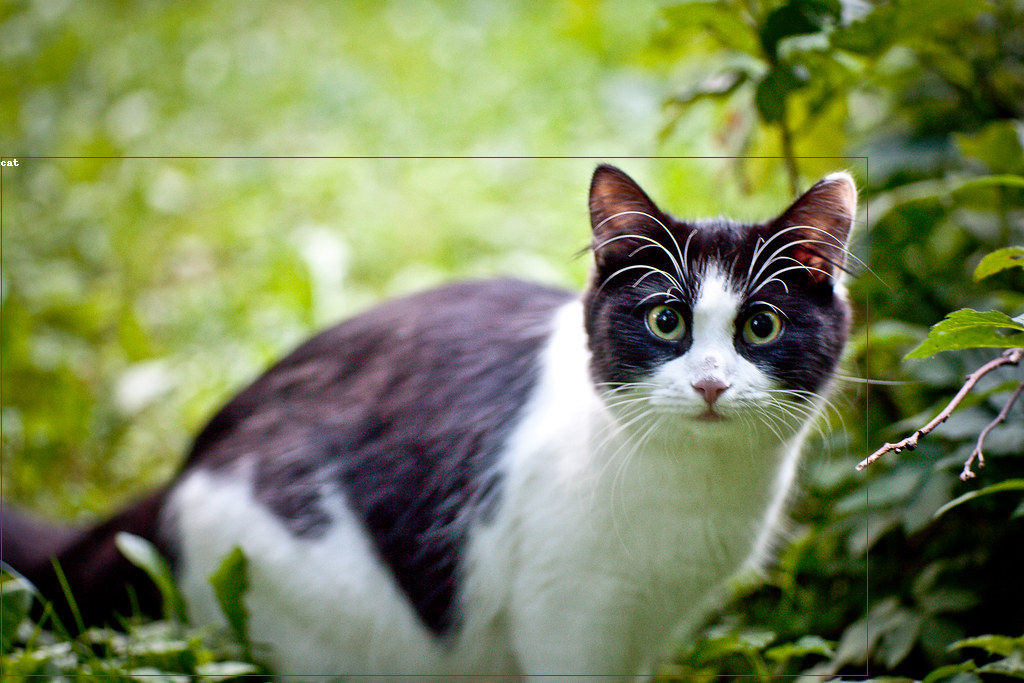

In [ ]:
img